In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

Using TensorFlow backend.


In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 2000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.01 #0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.10)
params.platforms.discount = float(0.0) # float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 1 #for TRB 
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.2
params.d2d.B_Marketing = 0.0
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5 #for TRB
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 800
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [ ]:
# sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
#                                   kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

sim_rln = MaaSSim.simulators.simulate_RLn(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

In [7]:
sim_rln.RL['reward'].mean()

675.7646653249999

In [8]:
(sim_rln.RL['discount']).mean()

0.0

In [9]:
sim_rln.RL.to_csv('../RL_EXP/csv/800dqn_lr0.008_max60_333333_rev_only')

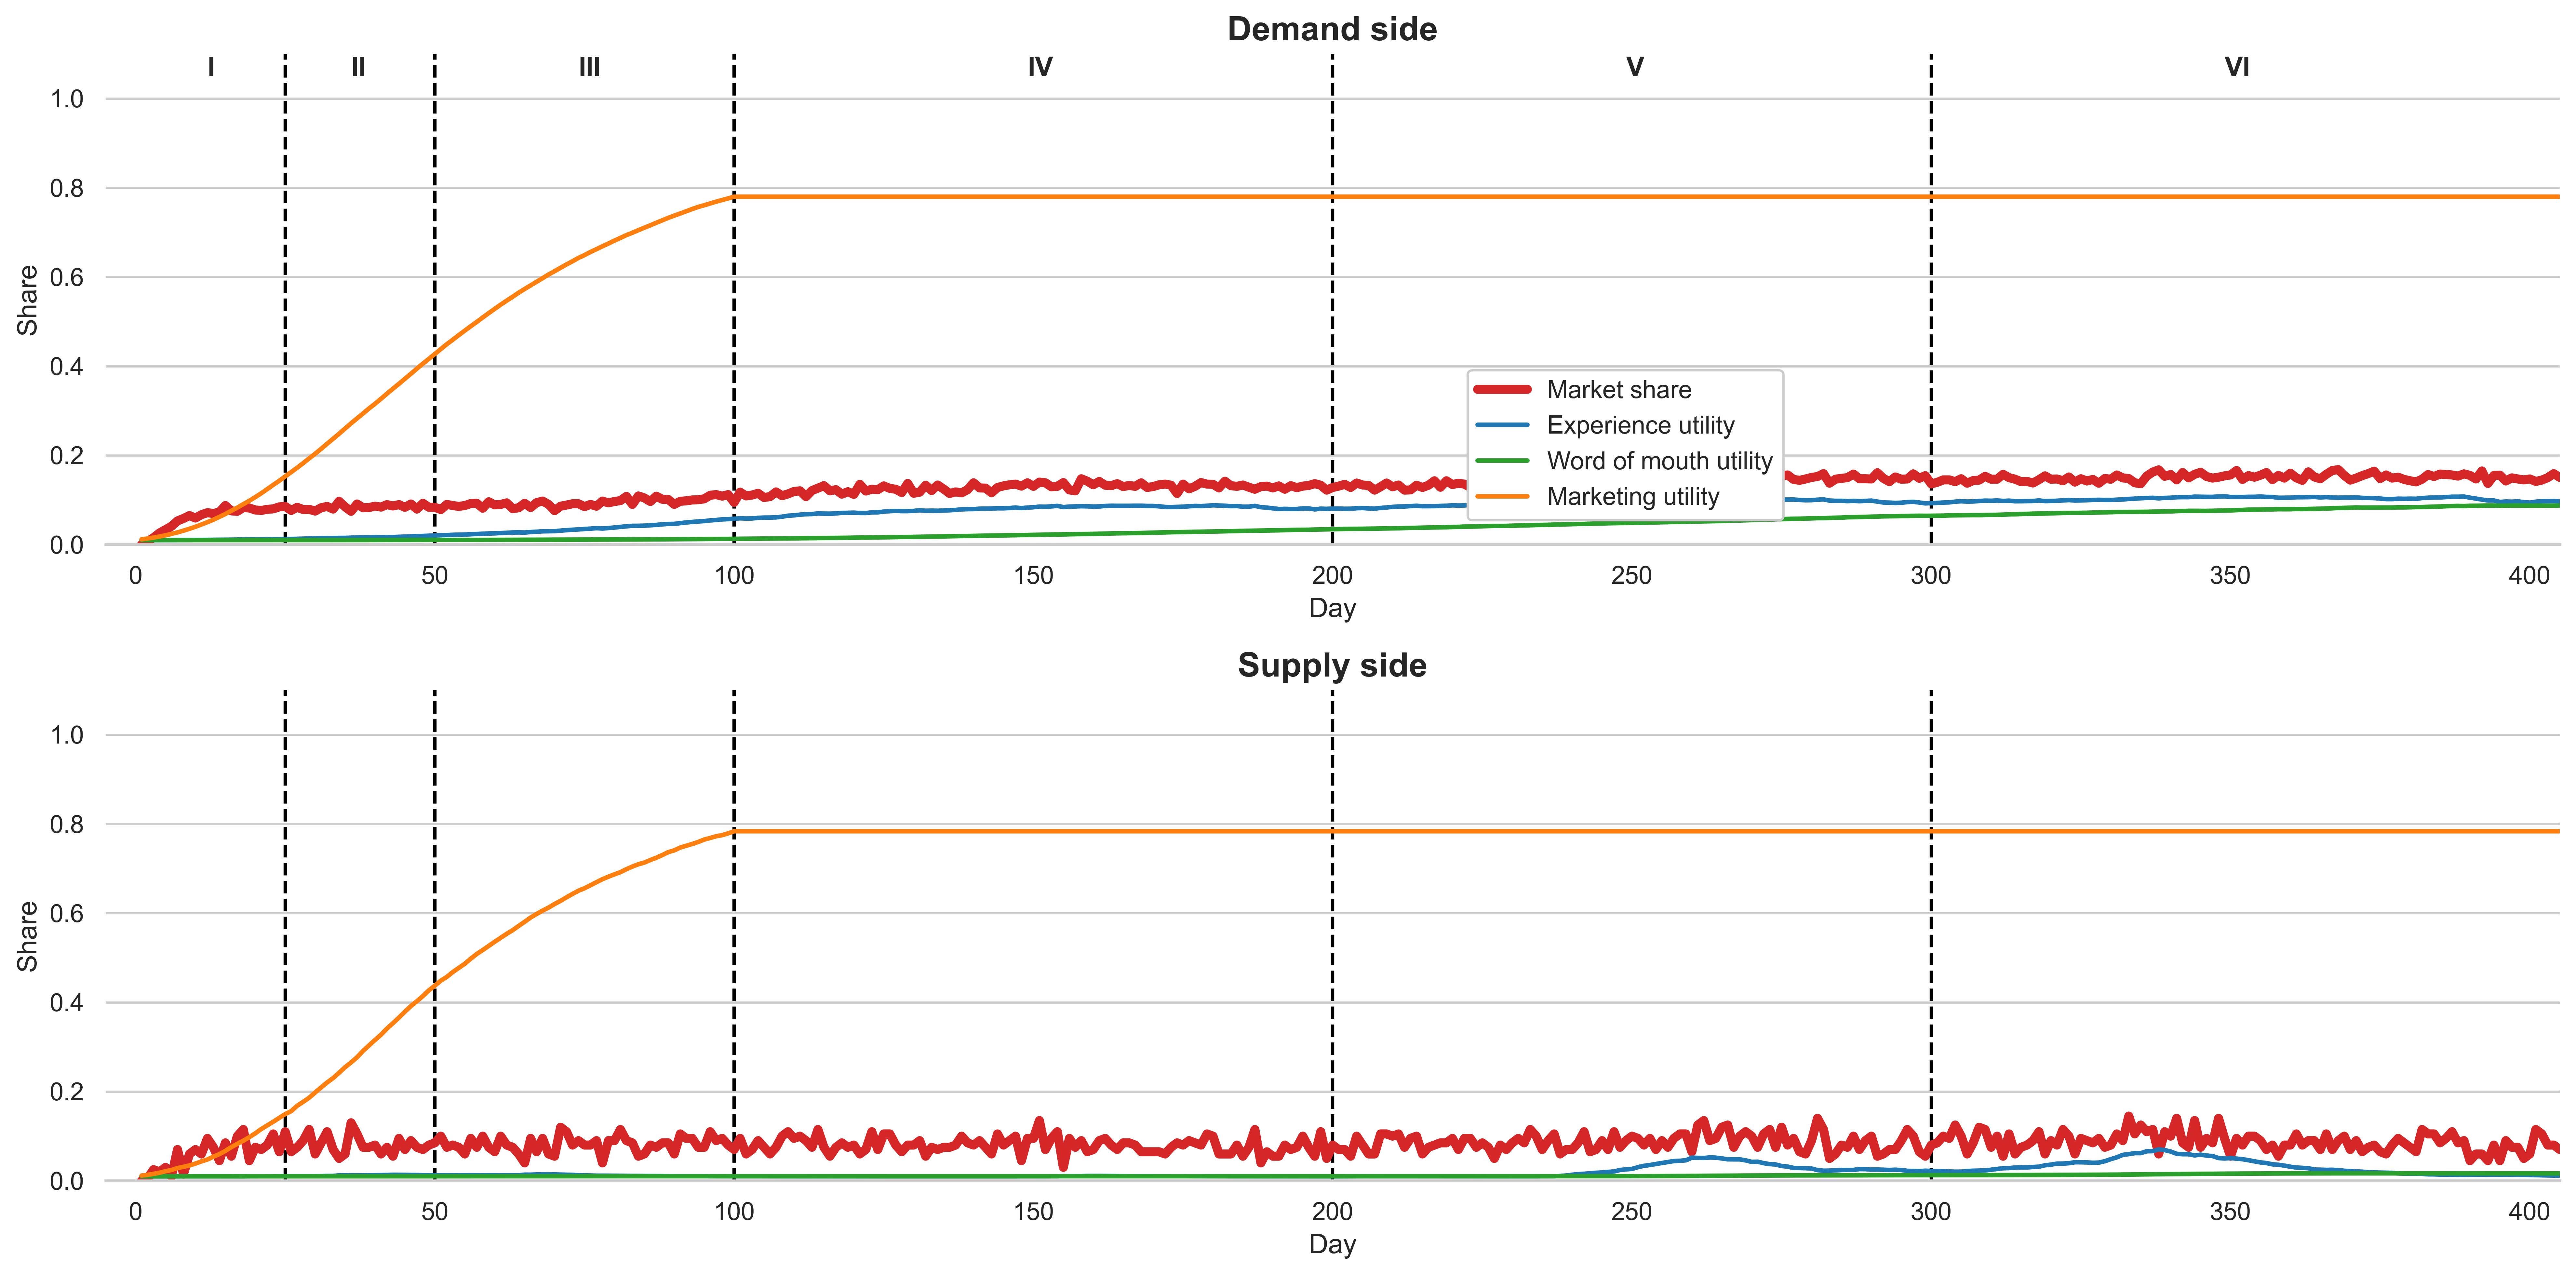

In [10]:
sim0 = sim_rln
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim0.params.nD):
            yw.append(sim0.res[d].pax_exp.WOM_U.mean())
            ym.append(sim0.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim0.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim0.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim0.params.nD):
            yw.append(sim0.res[d].veh_exp.WOM_U.mean())
            ym.append(sim0.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim0.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim0.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

In [14]:
sim = sim_rln

In [15]:
sim.res[100].veh_exp

nRIDES  nREJECTED  nDAYS_WORKED  DRIVING_TIME  IDLE_TIME  PICKUP_DIST  \
veh                                                                          
1       0.0        0.0           7.0           0.0        0.0         0.00   
2       0.0        0.0           9.0           0.0        0.0         0.00   
3       0.0        0.0           4.0           0.0        0.0         0.00   
4       0.0        0.0           5.0           0.0        0.0         0.00   
5       0.0        0.0           7.0           0.0        0.0         0.00   
..      ...        ...           ...           ...        ...          ...   
196     0.0        0.0           4.0           0.0        0.0         0.00   
197     0.0        0.0           8.0           0.0        0.0         0.00   
198     0.0        0.0           9.0           0.0        0.0         0.00   
199     0.0        0.0           7.0           0.0        0.0         0.00   
200    14.0        0.0           9.0       13649.0     7170.0        78.83   

     DRIVING_DIST  REVENUE     COST  COMMISSION  ...  \
veh                                              ...   
1            0.00   0.0000   0.0000      0.0000  ...   
2            0.00   0.0000   0.0000      0.0000  ...   
3            0.00   0.0000   0.0000      0.0000  ...   
4            0.00   0.0000   0.0000      0.0000  ...   
5            0.00   0.0000   0.0000      0.0000  ...   
..            ...      ...      ...         ...  ...   
196          0.00   0.0000   0.0000      0.0000  ...   
197          0.00   0.0000   0.0000      0.0000  ...   
198          0.00   0.0000   0.0000      0.0000  ...   
199          0.00   0.0000   0.0000      0.0000  ...   
200        136.49  75.4732  34.1225     13.3188  ...   

     IS_REJECTED_BY_TRAVELLER  ARRIVES_AT_PICKUP  MEETS_TRAVELLER_AT_PICKUP  \
veh                                                                           
1                           0                0.0                          0   
2                           0                0.0                          0   
3                           0                0.0                          0   
4                           0                0.0                          0   
5                           0                0.0                          0   
..                        ...                ...                        ...   
196                         0                0.0                          0   
197                         0                0.0                          0   
198                         0                0.0                          0   
199                         0                0.0                          0   
200                         0             7883.0                          0   

     DEPARTS_FROM_PICKUP ARRIVES_AT_DROPOFF  CONTINUES_SHIFT  \
veh                                                            
1                    0.0                0.0                0   
2                    0.0                0.0                0   
3                    0.0                0.0                0   
4                    0.0                0.0                0   
5                    0.0                0.0                0   
..                   ...                ...              ...   
196                  0.0                0.0                0   
197                  0.0                0.0                0   
198                  0.0                0.0                0   
199                  0.0                0.0                0   
200                420.0             5766.0                0   

     STARTS_REPOSITIONING  REPOSITIONED  DECIDES_NOT_TO_DRIVE  ENDS_SHIFT  
veh                                                                        
1                       0             0                     0         0.0  
2                       0             0                     0         0.0  
3                       0             0                     0         0.0  
4                   

In [13]:
df = pd.DataFrame()
np = []
nv = []
rev = []
for d in range(0,sim.params.nD):
    np.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
    nv.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    rev.append(sim.res[d].pax_exp.plat_revenue.sum())

df['nP_share'] = np
df['nV_share'] = nv
df['Platform_rev'] = rev

df.to_csv('csv/baseline_fast_rev_only.csv')

NameError: name 'sim' is not defined

In [22]:
sim.res[100].pax_exp.plat_revenue

pax
0       0.00000
1       0.00000
2       0.00000
3       0.00000
4       0.00000
         ...   
1995    0.00000
1996    0.00000
1997    0.00000
1998    0.00000
1999    3.35744
Name: plat_revenue, Length: 2000, dtype: float64

In [ ]:
df = pd.read_csv('csv/baseline_fast_h.csv')

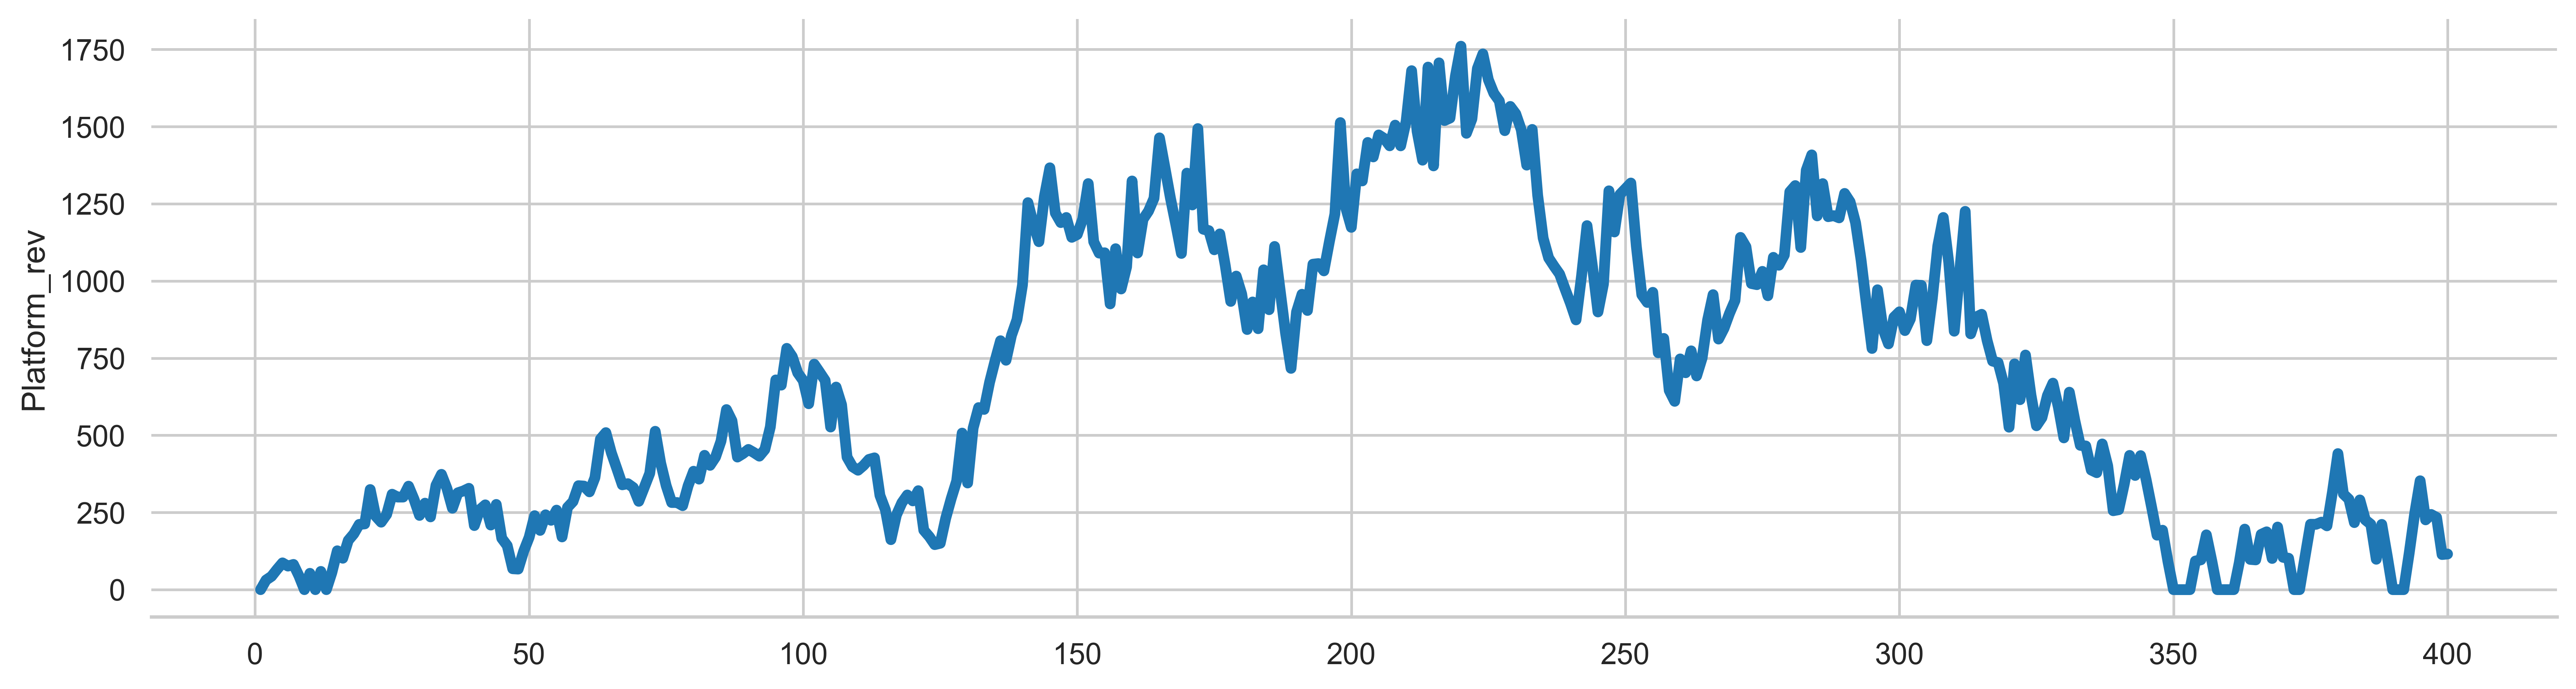

In [23]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, figsize=(16,4))
sns.despine(left=True)

sns.lineplot(x=lx,y=df.Platform_rev, lw=4)

<AxesSubplot:ylabel='Platform_rev'>

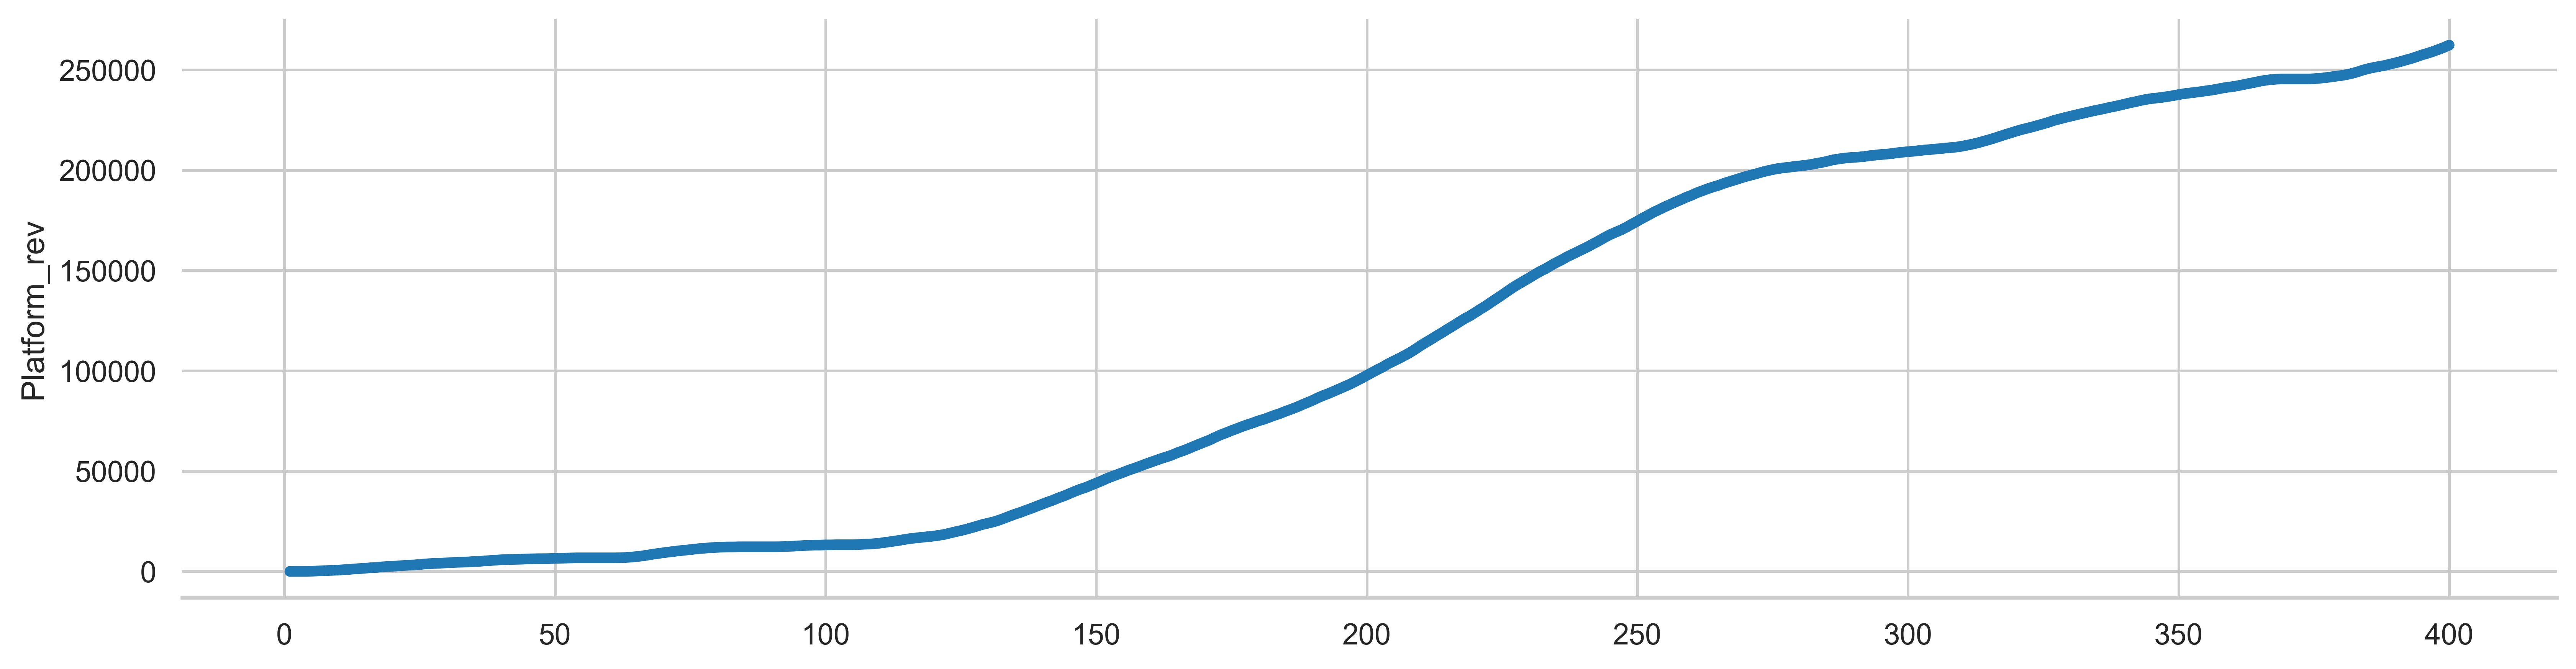

In [22]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, figsize=(16,4))
sns.despine(left=True)

sns.lineplot(x=lx,y=df.Platform_rev.cumsum(), lw=4)

In [46]:
sim.platforms.fare[1]

1.2

In [16]:
sim

In [34]:
df = pd.read_csv('csv/baseline_fast_rev_0.5nP_0.5nV.csv')
df

Unnamed: 0  nP_share  nV_share  Platform_rev
0             0    0.0000     0.000       0.00000
1             1    0.0070     0.005      15.29592
2             2    0.0155     0.010      23.63168
3             3    0.0250     0.010      20.00924
4             4    0.0400     0.035      59.92720
..          ...       ...       ...           ...
395         395    0.2650     0.200    1031.77092
396         396    0.2720     0.210    1250.62672
397         397    0.2565     0.190    1178.18820
398         398    0.2725     0.115    1081.69752
399         399    0.2735     0.160    1266.17554

[400 rows x 4 columns]

In [20]:
df.Platform_rev.mean()

655.7543860000001

In [9]:
df.Platform_rev.mean()

604.4805835000008

In [10]:
df.Platform_rev.cumsum()

0           0.00000
1           0.00000
2           0.00000
3           0.00000
4          19.35682
           ...     
395    237676.85714
396    238813.95026
397    239708.00418
398    240677.55240
399    241792.23340
Name: Platform_rev, Length: 400, dtype: float64

In [30]:
df.Platform_rev.mean()

582.0985324000001

In [31]:
df.Platform_rev.cumsum()

0           0.00000
1          13.69388
2          44.78640
3          90.17320
4         149.92560
           ...     
395    228671.27896
396    229671.55656
397    230685.35376
398    231702.18296
399    232839.41296
Name: Platform_rev, Length: 400, dtype: float64

In [28]:
df.Platform_rev.mean()

553.2985028000002

In [35]:
df.Platform_rev.cumsum()

0           0.00000
1          15.29592
2          38.92760
3          58.93684
4         118.86404
           ...     
395    216542.71314
396    217793.33986
397    218971.52806
398    220053.22558
399    221319.40112
Name: Platform_rev, Length: 400, dtype: float64

In [26]:
df.Platform_rev.mean()

602.1789189999998

In [33]:
df.Platform_rev.cumsum()

0           0.00000
1           0.00000
2          13.21864
3          53.39316
4          80.25430
           ...     
395    236196.97054
396    237392.87096
397    238450.85096
398    239605.73920
399    240871.56760
Name: Platform_rev, Length: 400, dtype: float64

In [36]:
20/582

0.03436426116838488

In [ ]:
=====================================================================================

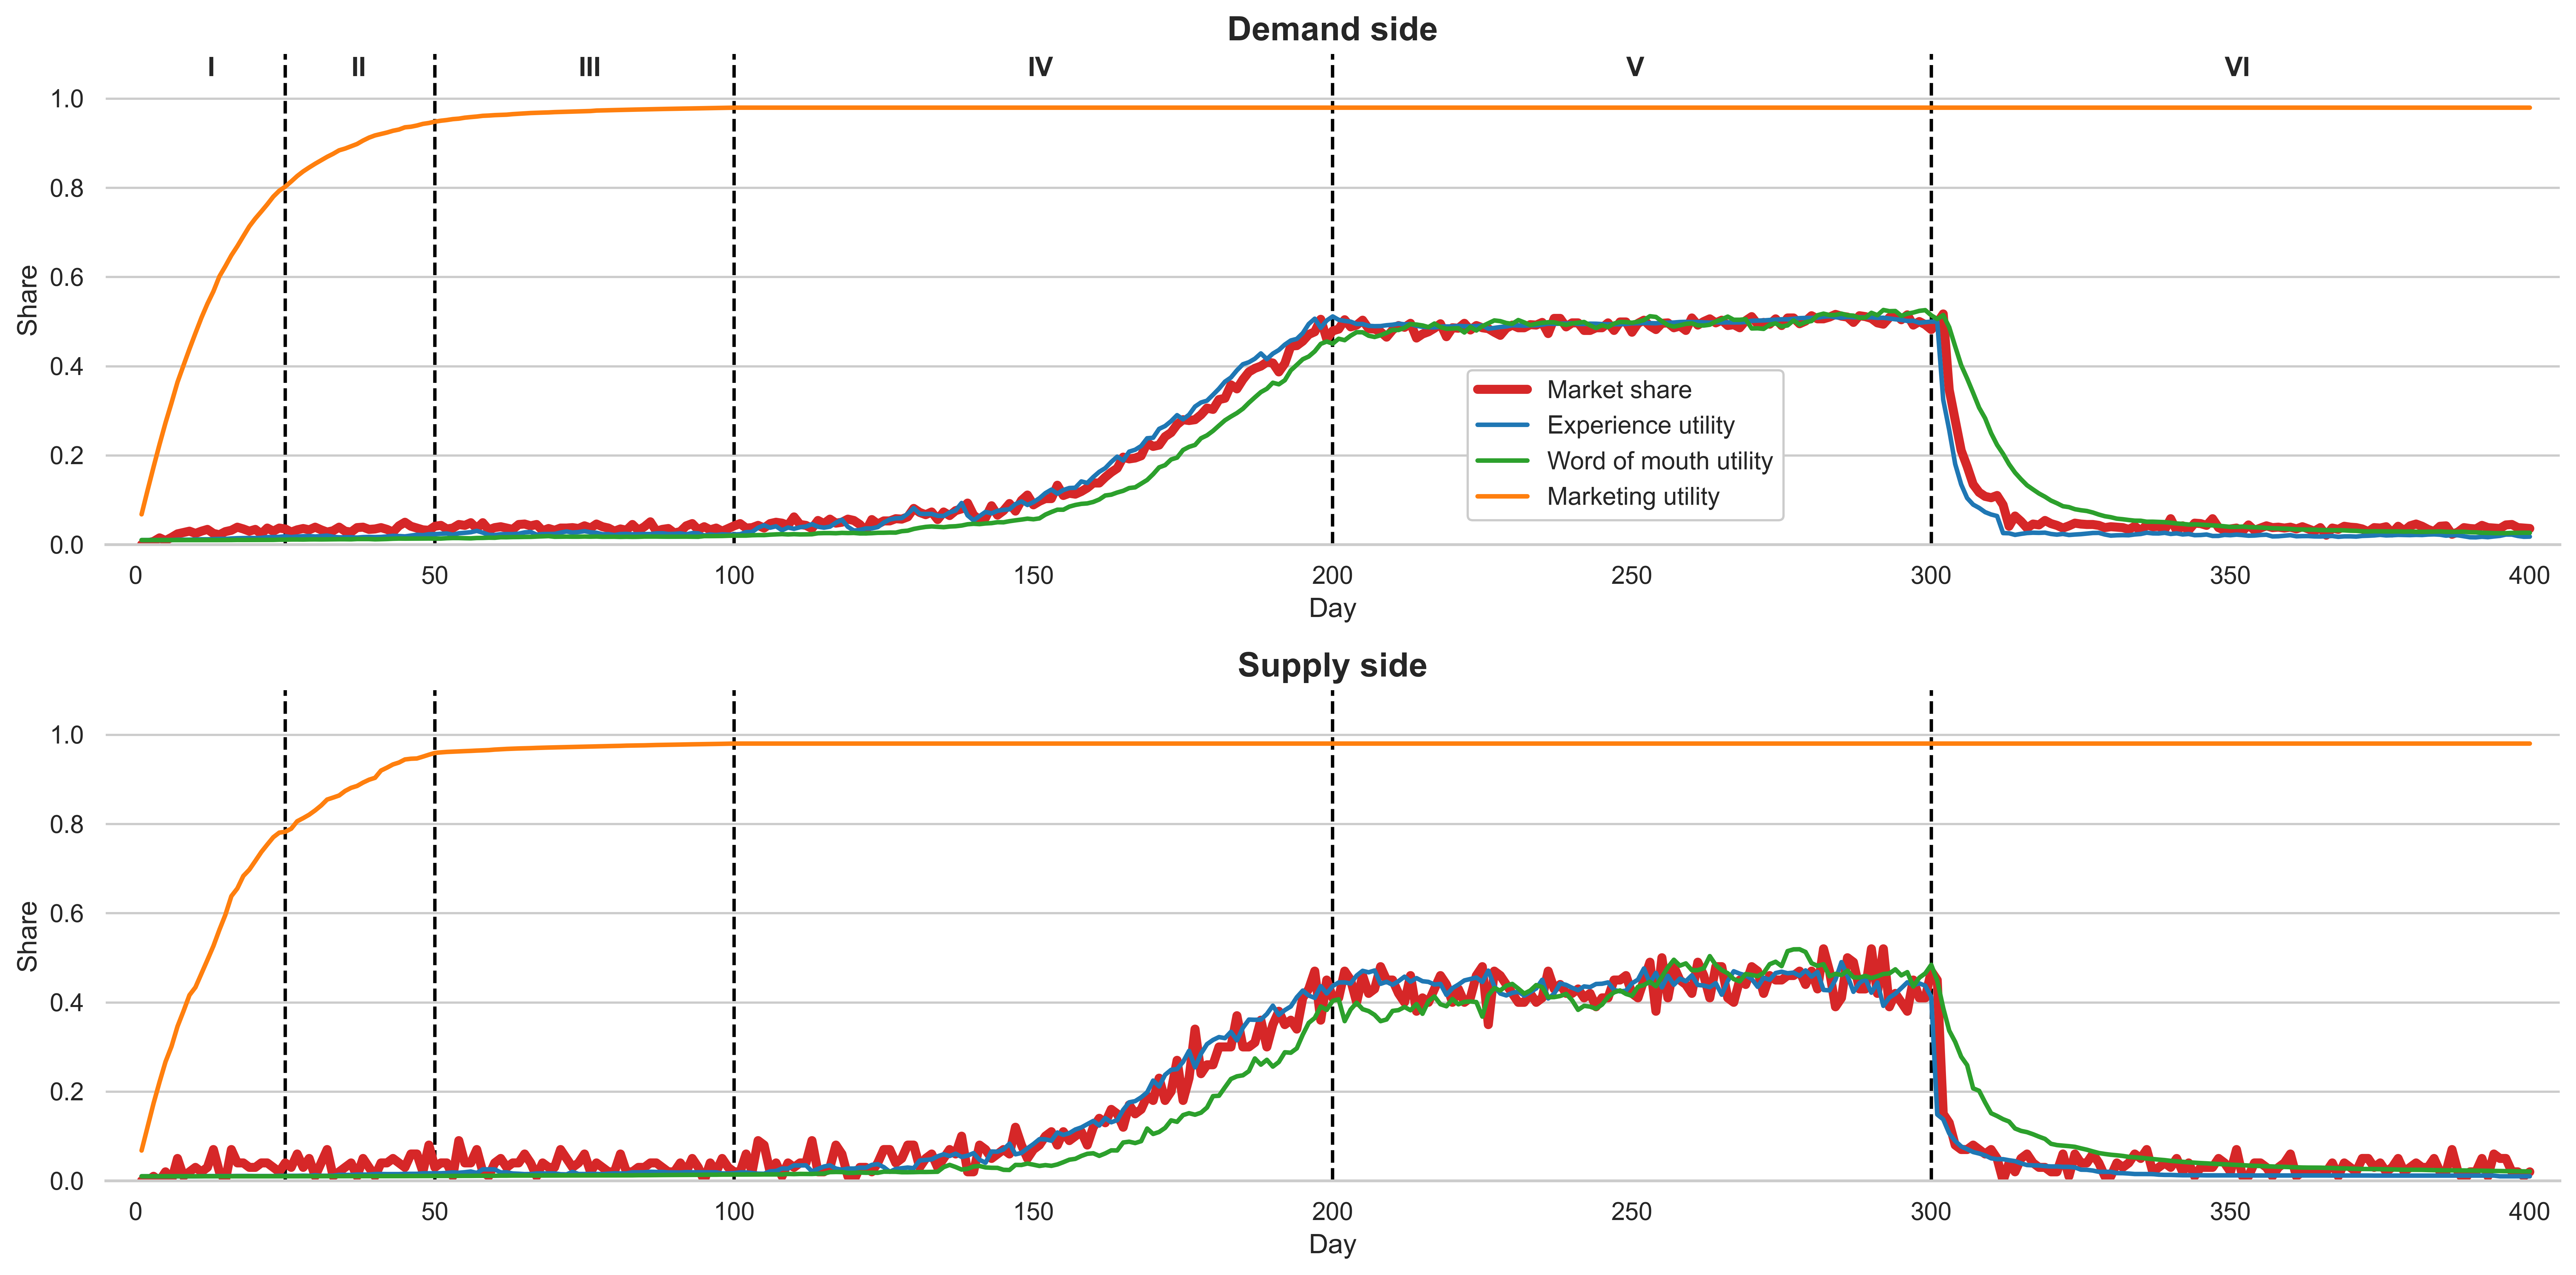

In [7]:
# nV=100, nP=1000, params.d2d.m = 7, and params.d2d.learning_d = 5
# marketing = 1-100, disc= 100-200, coms_0.5=300-400 

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

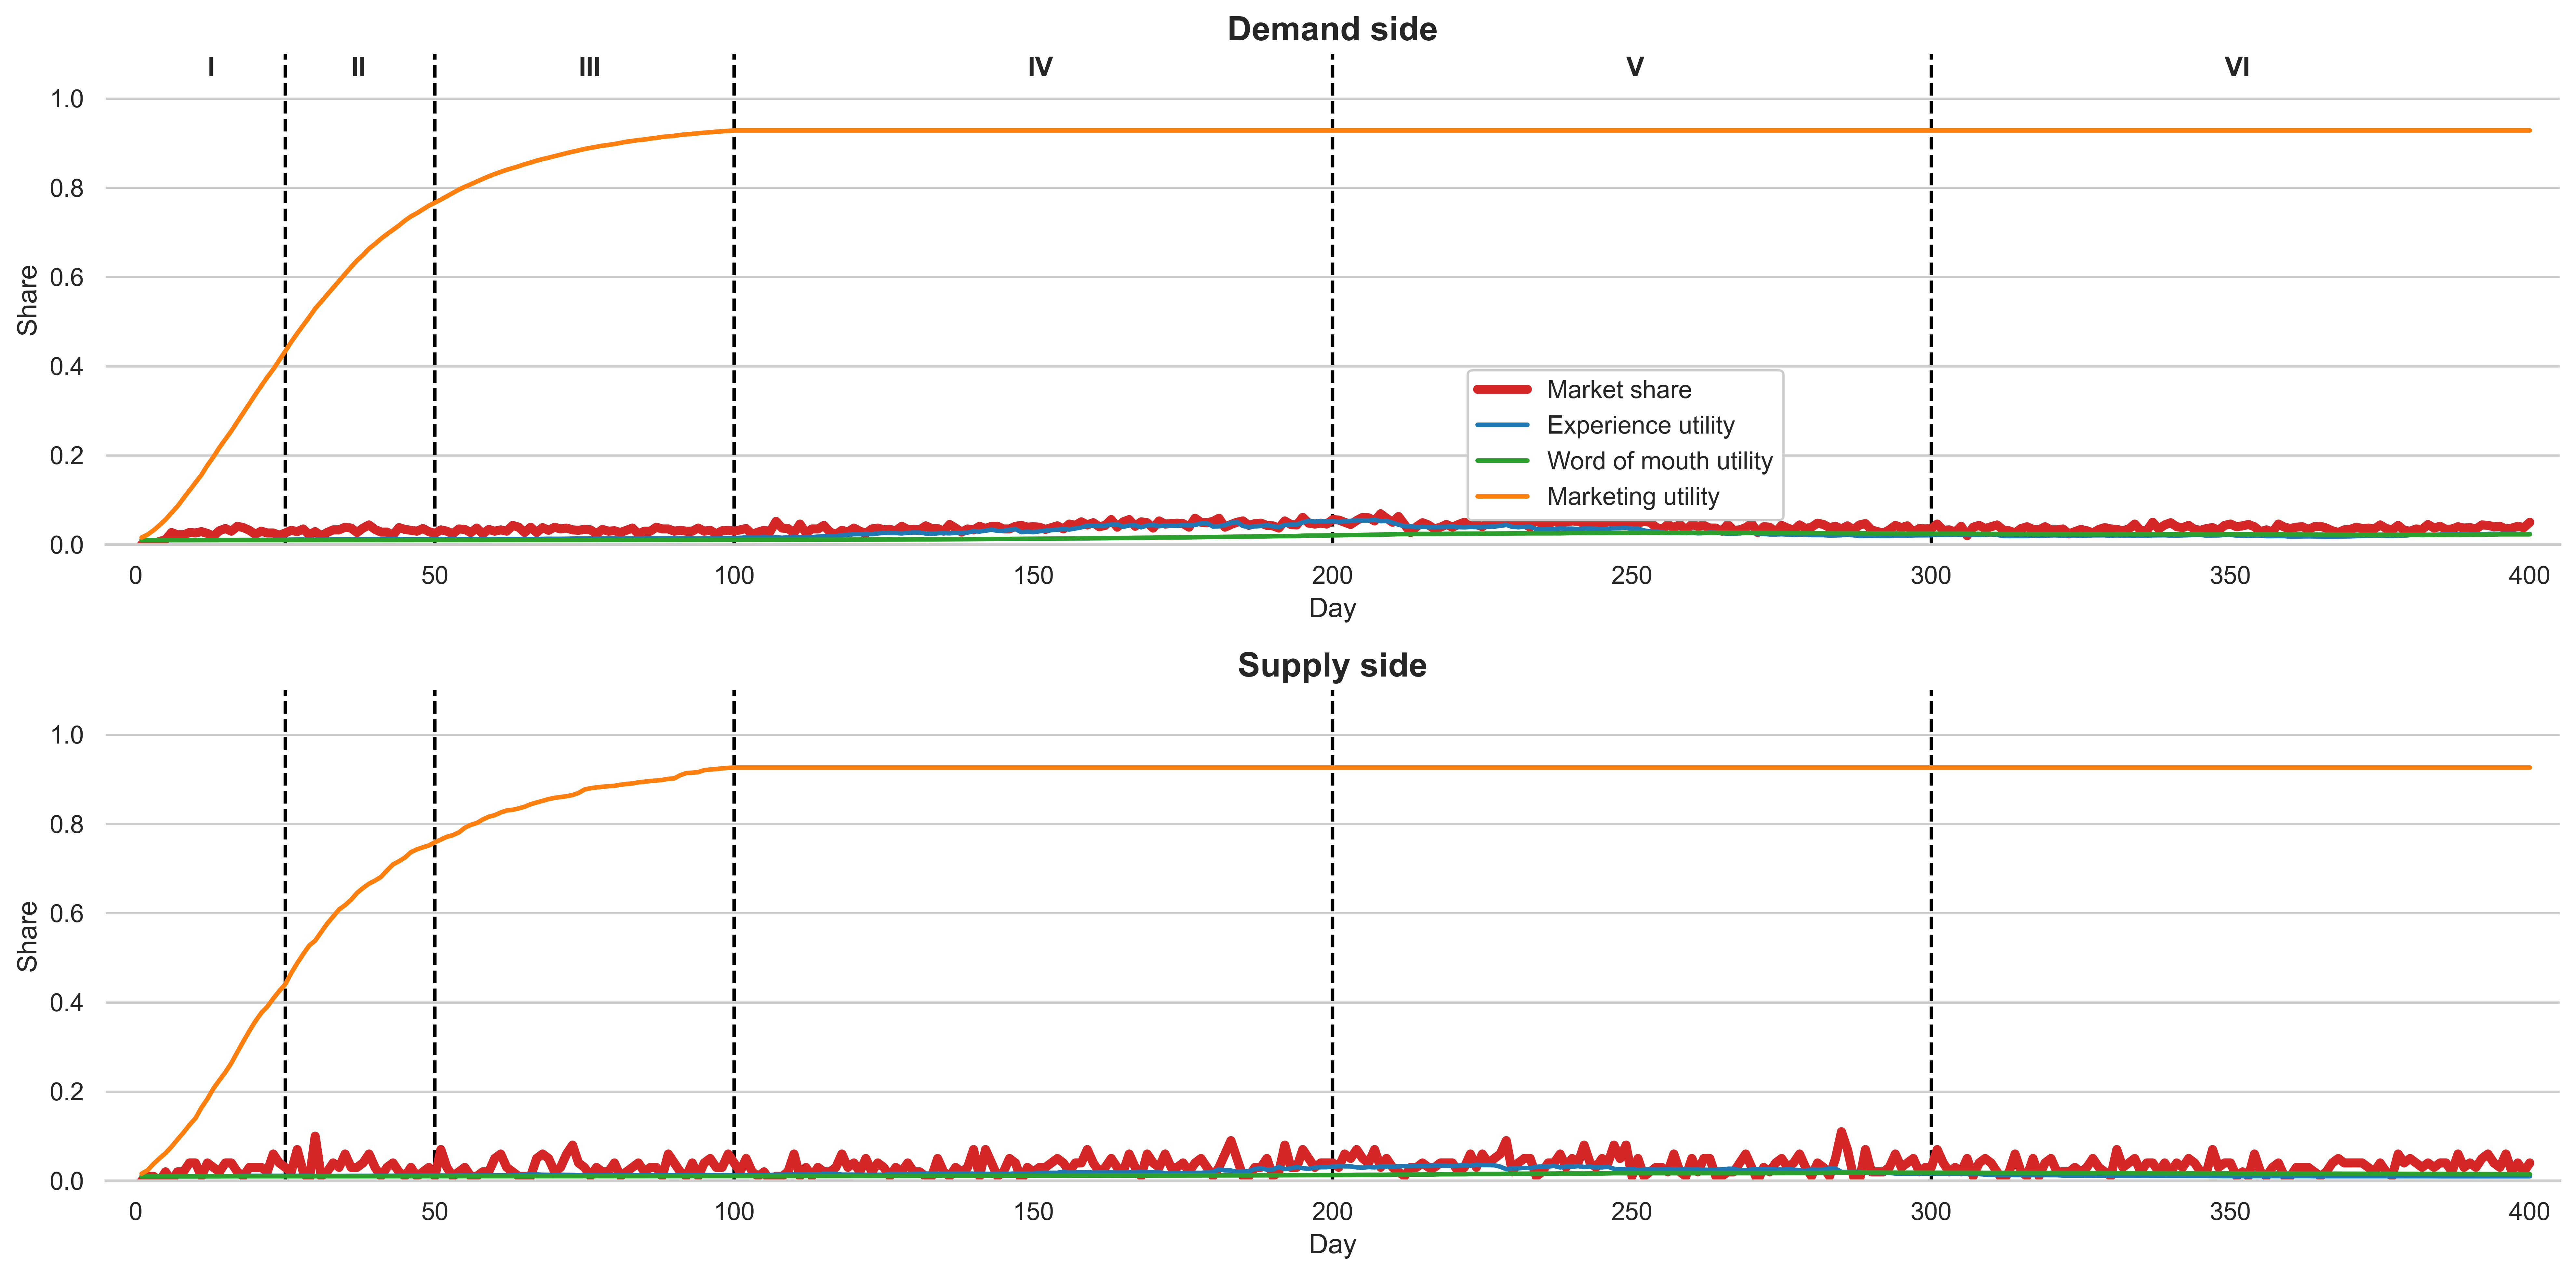

In [7]:
# nV=100, nP=1000, params.d2d.m = 7, and params.d2d.learning_d = 2
# marketing = 1-100, disc= 100-200, coms_0.5=300-400 

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

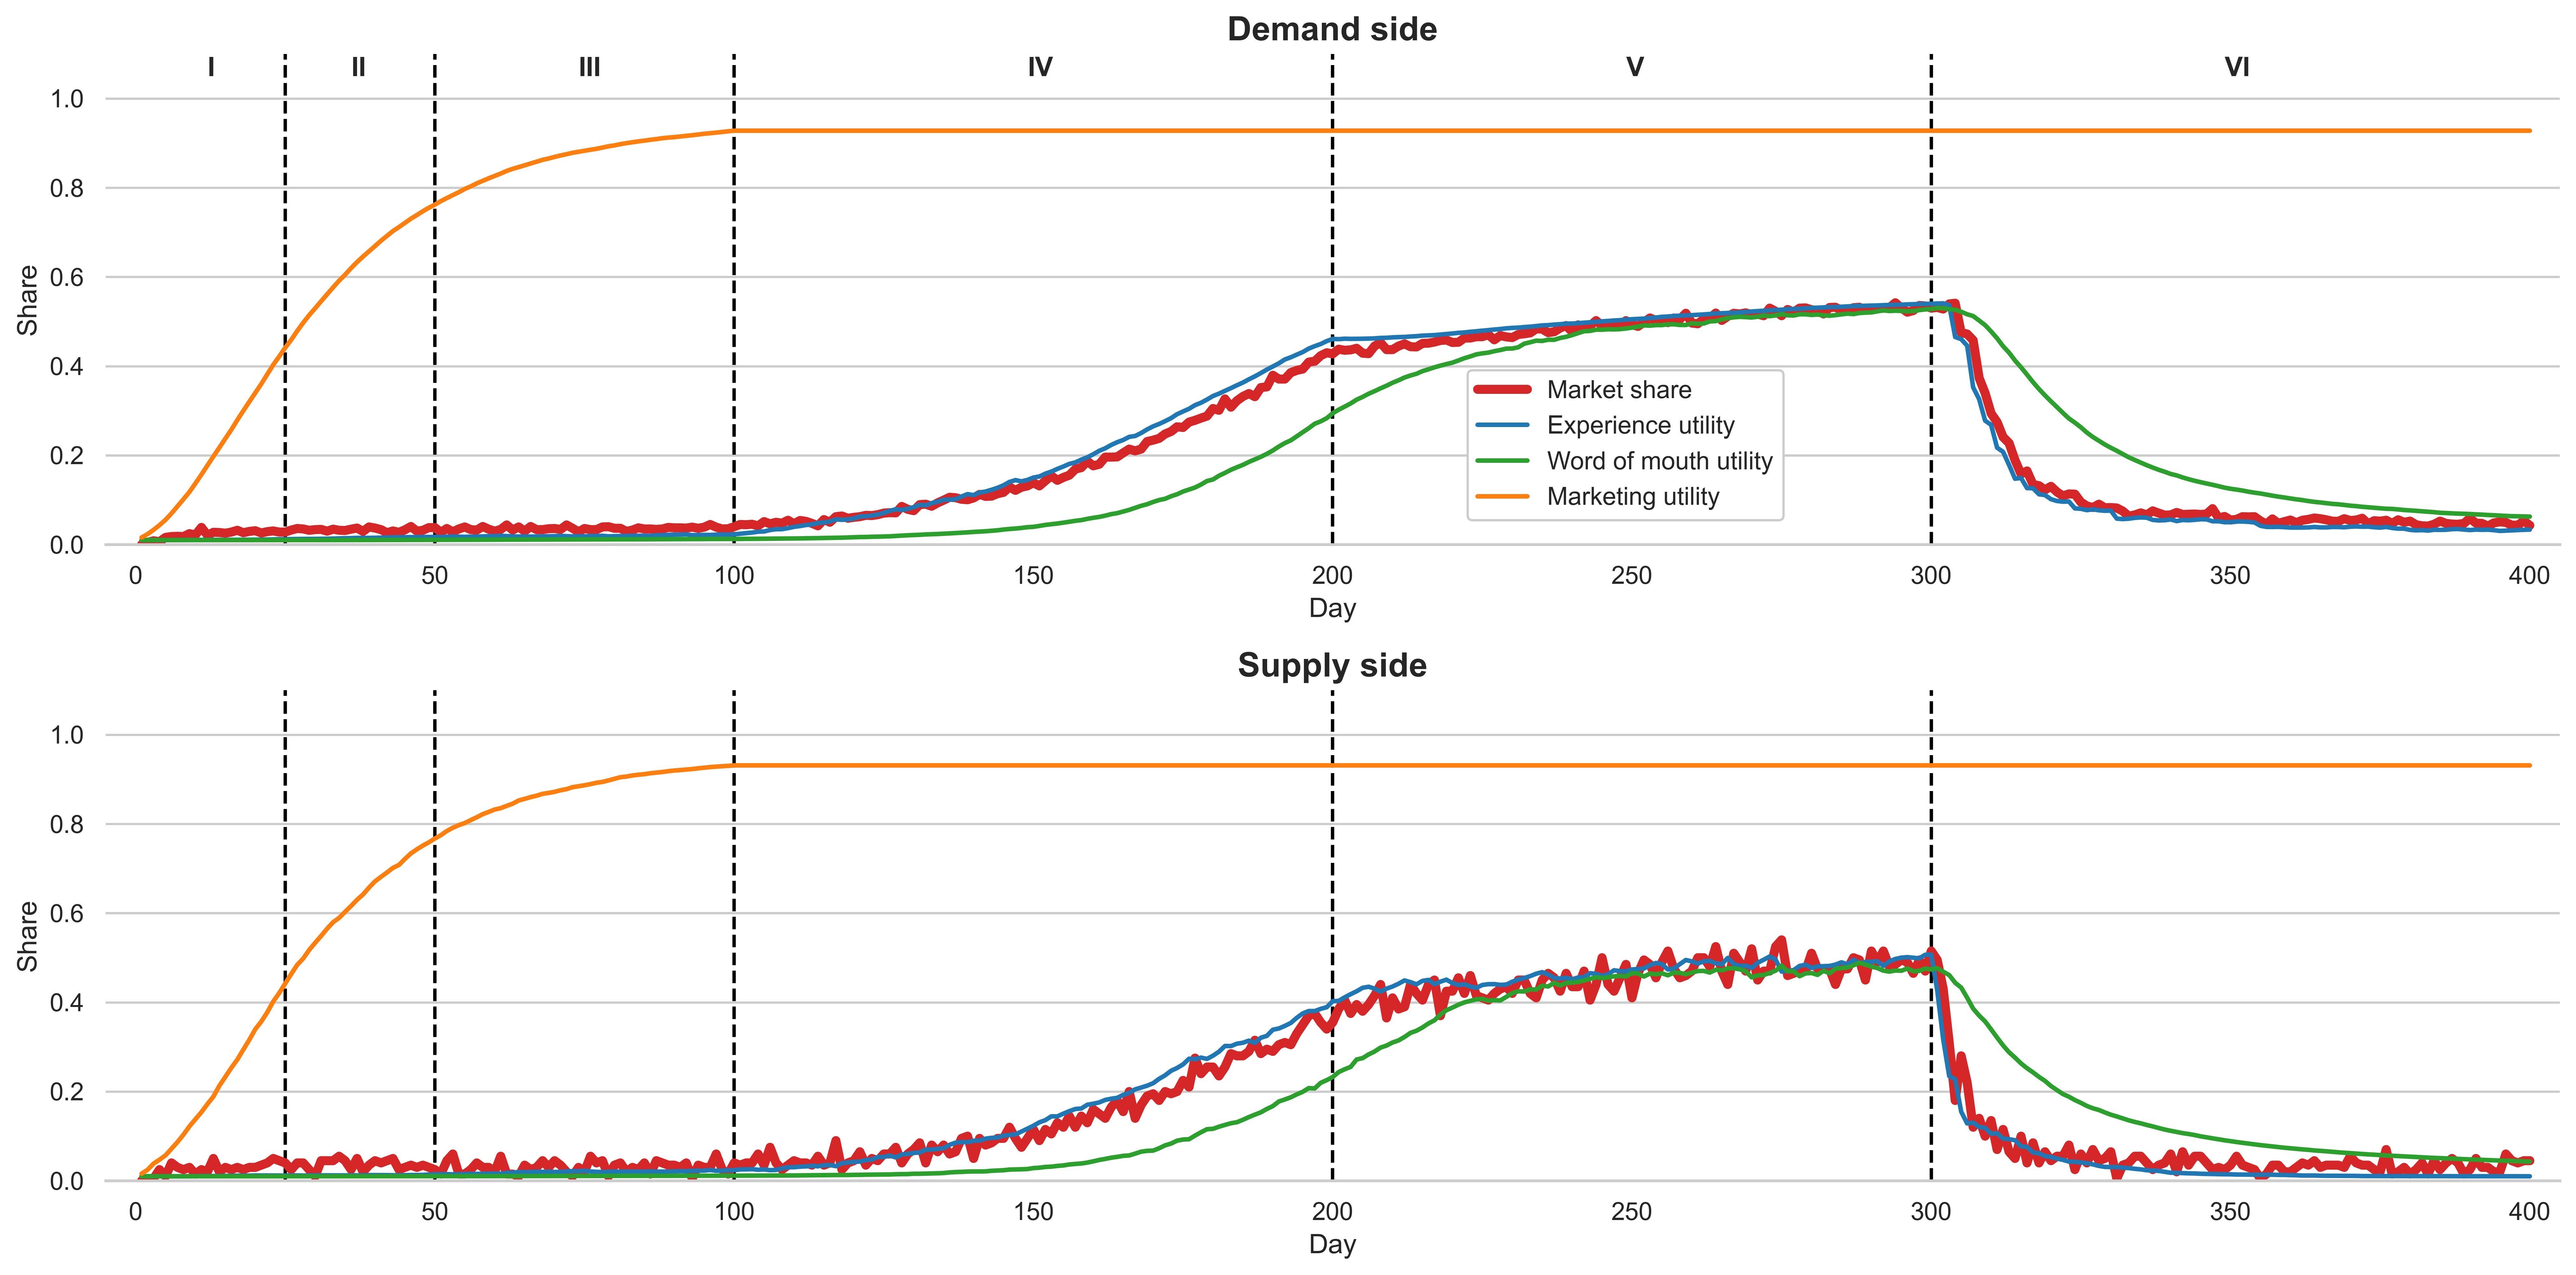

In [7]:
# nV=200, nP=2000, params.d2d.m = 7, and params.d2d.learning_d = 2
# marketing = 1-100, disc= 100-200, coms_0.5=300-400 

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

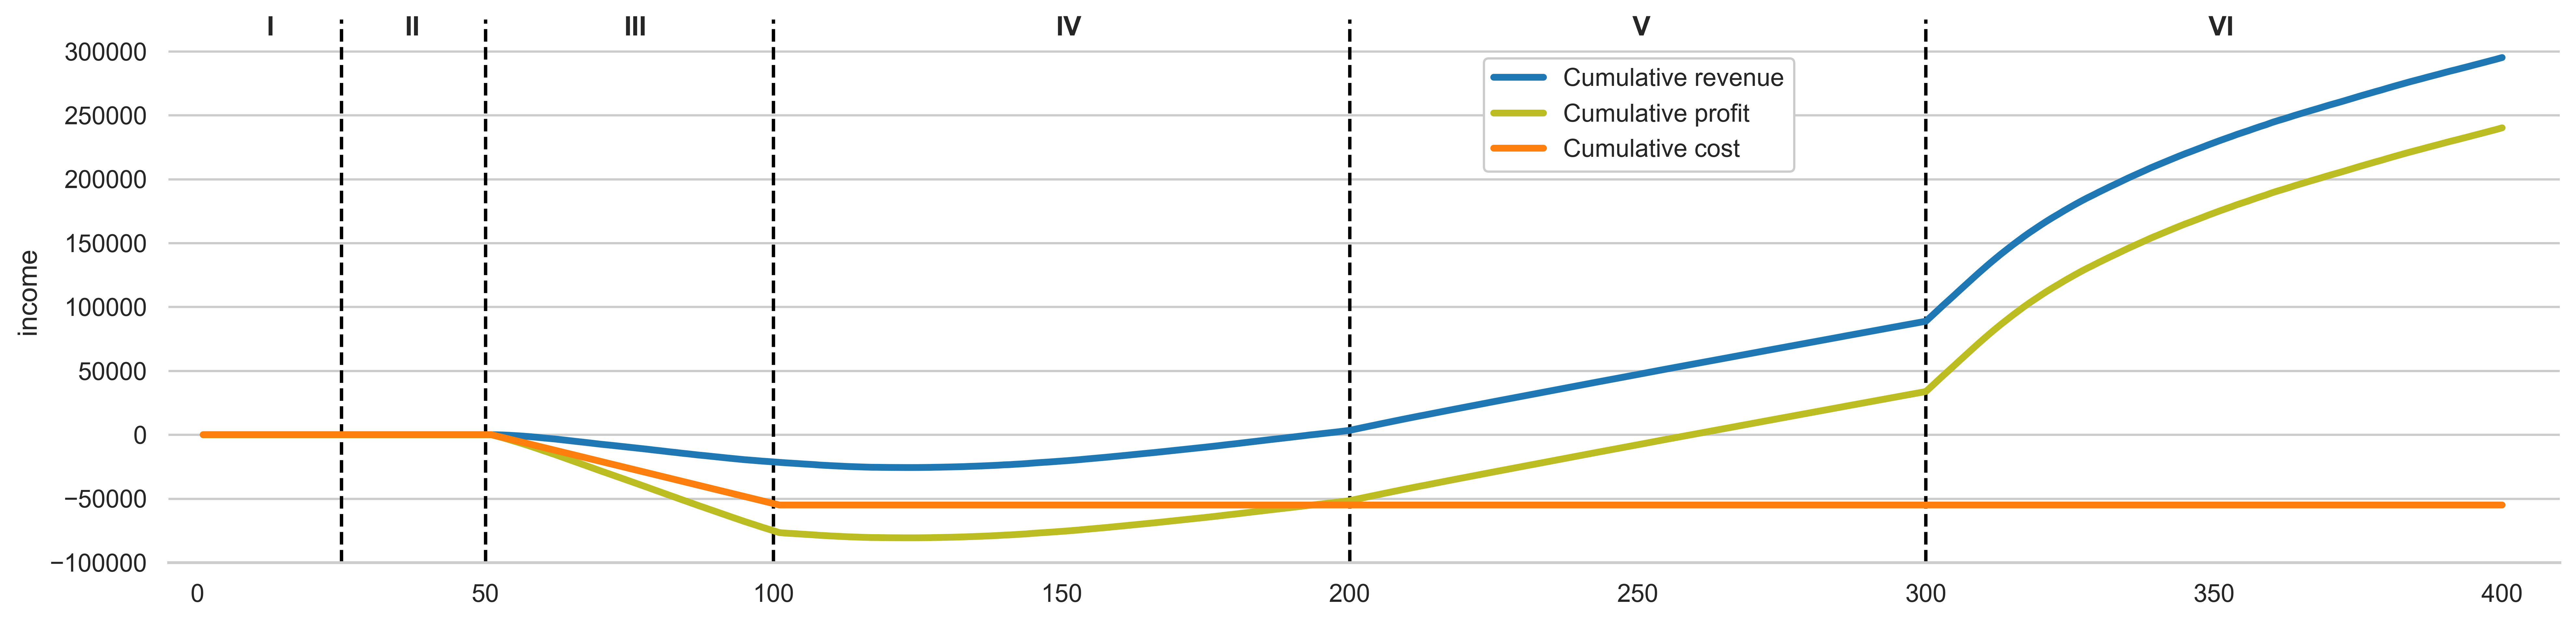

In [177]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,4))
sns.despine(left=True)

x = []
ypr = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    ypr.append(df[df.OUT==False].plat_profit.sum())
x = [i for i in range(1,len(ypr)+1)]

df = pd.Series(ypr).to_frame()
df.columns = ['income']
marketing_costs = 0.5
df['marketing costs']=df.apply(lambda x: -marketing_costs*2200 if x.name >50 and x.name<=100 else 0, axis = 1).astype(int)
df['profit']=df.income + df['marketing costs']

sns.lineplot(x=x, y=df.income.cumsum(), lw=3, label = 'Cumulative revenue', color='C0')#, marker='o')
sns.lineplot(x=x, y=df.profit.cumsum(), lw=3, label = 'Cumulative profit', color='C8')#, marker='o')
sns.lineplot(x=x, y=df['marketing costs'].astype(int).cumsum(), lw=3, label = 'Cumulative cost', color='C1')#, marker='o')

ax.grid(axis='x')
ax.vlines([25, 50, 100, 200, 300], -100000, 325000, linestyles='dashed', colors='black')
# sns.lineplot(x=x, y=ypr, label = 'plat_profit')#, marker='o')
sns.despine(left=True)
ax.set(xlim=(-5,410), ylim=(-100000,325000))
ax.legend(framealpha=1, loc=(0.55,0.72))

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,312500),(36,312500),(74,312500),(149,312500),(249,312500),(349,312500)]
    ax.annotate(value[i], xy =coords[i], fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig5.png')

In [21]:
df = pd.read_csv('csv/baseline_fast.csv')
df

Unnamed: 0  nP_share  nV_share  Platform_rev
0             0    0.0000     0.000       0.00000
1             1    0.0120     0.005      21.47460
2             2    0.0220     0.015      34.04332
3             3    0.0300     0.025      42.06120
4             4    0.0325     0.015      49.05952
..          ...       ...       ...           ...
395         395    0.1665     0.115    1123.47240
396         396    0.1555     0.080    1085.47640
397         397    0.1495     0.105     993.22100
398         398    0.1590     0.060    1099.28520
399         399    0.1540     0.090    1055.16860

[400 rows x 4 columns]

In [22]:
df.Platform_rev.max()

4098.8442

In [ ]:
2638.8502